## Analysis of how the journal impact factor impacts the citation 

In [2]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression

Data for perovskite devices are downloaded from the Perovskite Database Project in December 2021. <br>
The highest efficiency for each paper was extracted, and the corresponding citation data was downloaded from Crossref on 2022-03-06 <br>
Journal impact factors were obtained from the InCites Journal Citation Reports from Clariavate on 2022-03-26

In [4]:
# Path to data
filename_impact = "JCR2021.xlsx"
filename_citation = 'Citation_data.csv'
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "data")
path_data_impact = os.path.join(path_data_folder, filename_impact)
path_data_citation = os.path.join(path_data_folder, filename_citation)
path_figure_folder = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), "Figures")

# Read in data
impact_data = pd.read_excel(path_data_impact, skiprows=2)
citation_data = pd.read_csv(path_data_citation)

#### Helper functions

In [5]:
def generate_time_bins(data, start, interval, periods):
    """data is a pandas series. return a pandas series binned with a start date and period numbers of intervals with length intervals"""
    bins_dt = pd.date_range(start, freq=interval, periods=periods)
    bins_str = bins_dt.astype(str).values
    if interval == "1Y":
        date_labels = [x[0:4] for x in bins_str[0:-1]]
        date_labels = [str(int(x) + 1) for x in date_labels] # Compensate for that year string starts on last of december
    else:
        date_labels = ['({}, {}]'.format(bins_str[i - 1], bins_str[i]) for i in range(1, len(bins_str))]
    return pd.cut(data.astype(np.int64) // 10**9,
                              bins=bins_dt.astype(np.int64) // 10**9,
                              labels=date_labels)
    
def save_figure(path_figure_folder, fileName, fig):
    fig.savefig(os.path.join(path_figure_folder, (fileName + '.tif')), dpi=300, format='tif')
    fig.savefig(os.path.join(path_figure_folder, (fileName + '.png')), dpi=300, format='png')
    fig.savefig(os.path.join(path_figure_folder, (fileName + '.pdf')), dpi=300, format='pdf')

##### Data treatment

In [6]:
# List of all journals where we have published perovskite device data
perovskite_journals = set(list(citation_data["Ref_journal"]))
print(f"There are {len(perovskite_journals)} journlas with perovskite data")

There are 335 journlas with perovskite data


In [7]:
# In the list of journals there are a number of doublets which need to be sorted out
citation_data["Ref_journal"].replace("Energy Environ. Sci.", "Energy & Environmental Science", inplace=True)
citation_data["Ref_journal"].replace( "J. Mater. Chem. A", "Journal of Materials Chemistry A", inplace=True)
citation_data["Ref_journal"].replace( "J. Mater. Chem. C", "Journal of Materials Chemistry C", inplace=True)
citation_data["Ref_journal"].replace( "phys. chem. chem. phys.", "Physical Chemistry Chemical Physics", inplace=True)
citation_data["Ref_journal"].replace( "Chem. Commun.", "Chemical Communications", inplace=True)
citation_data["Ref_journal"].replace( "Chem. Sci.", "Chemical Science", inplace=True)
citation_data["Ref_journal"].replace( "RSC Adv.", "RSC Advances", inplace=True)
citation_data["Ref_journal"].replace( "physica status solidi (RRL) – Rapid Research Letters", "physica status solidi (RRL) - Rapid Research Letters", inplace=True)

Check if there are any of the perovskite journals which not is in the impact factor datafile

In [8]:
# Add columns where journal names are converted to lower case letters
citation_data["Ref_journal_lower"] = citation_data["Ref_journal"].str.lower()
impact_data["journal_lower"] = impact_data["Full Journal Title"].str.lower()

# Identify missing journals
missing_journals = []
for journal in list(set(citation_data["Ref_journal_lower"])):
    if journal not in impact_data["journal_lower"].values:
        missing_journals.append(journal)

print(f"There are {len(missing_journals)} not in the impact dataset")  

There are 95 not in the impact dataset


There are 95 perovskite journals not in the impact factor dataset. Impact factors for those journals have been manually extracted whenever possible. 20 of those are conference proceedings where no impact factor was found.<br>
<br>
Read in the manually extracted impact factors nad complement the citation data with impact factor data 

In [9]:
# Read in impact factor data
filename_impact_complemented = "missing_if_complement.xlsx"
path_data_impact_complement = os.path.join(path_data_folder, filename_impact_complemented)
impact_data_2 = pd.read_excel(path_data_impact_complement)

In [10]:
journal_if = {}
for journal in list(set(citation_data["Ref_journal_lower"])):
        journal_if[journal] = impact_data_2.loc[impact_data_2["Journal"]==journal, "IF"].iloc[0]

paper_if = []
for paper in citation_data["Ref_journal_lower"]:
    paper_if.append(journal_if[paper])
    
citation_data["Impact_factor"] = paper_if    

# Drop all entries with undefined IF (primarily from conference proceedings) which manually have been set to -1
citation_data.drop(citation_data[citation_data["Impact_factor"]==-1].index, inplace=True)
print(f"This leaves {len(citation_data)} entries")

This leaves 7267 entries


##### Furter data treatment

In [11]:
# Convert data strings to time stamps
citation_data['Date'] = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in citation_data['Ref_publication_date']]

# Bin the data with respect to publication time in 6M periods
citation_data["date_bins_half_year"] = generate_time_bins(data=citation_data["Date"], 
                                                          start="2011-06-01", 
                                                          interval="6M", 
                                                          periods=20)

# Bin the data with respect to publication time for hole years
citation_data["date_bins_years"] = generate_time_bins(data=citation_data["Date"], 
                                                          start="2010-01-01", 
                                                          interval="1Y", 
                                                          periods=13)

# Bin the data with respect to PCE
start = 0
end = 26
delta = 1
antal = int(round((end-start)/delta)) + 1
cut_bins = np.linspace(start, end, antal)
pce_cut_labels = np.linspace(start + delta / 2, end + delta / 2, antal)[:-1]
citation_data['PCE_bins'] = pd.cut(citation_data['JV_default_PCE'], bins=cut_bins, labels=pce_cut_labels)

# Logarithm of citation data. To prevent infinite values minimum citation rate is set to zero
citations = citation_data['Citations'].replace(0, 1, inplace=False)
citation_data['log_citations'] = np.log10(citations)

# Bin data with respect to impact factor
start = 0
end = 60
delta = 2
antal = int(round((end-start)/delta)) + 1
cut_bins = np.linspace(start, end, antal)
pce_cut_labels = np.linspace(start + delta / 2, end + delta / 2, antal)[:-1]
citation_data['IF_bins'] = pd.cut(citation_data['Impact_factor'], bins=cut_bins, labels=pce_cut_labels)

In [12]:
data = citation_data[["Ref_journal"]].groupby(by="Ref_journal").size().reset_index(name="count")
data["IF"] = citation_data[["Ref_journal", "Impact_factor"]].groupby(by="Ref_journal").mean().values
data["PCE_mean"] = citation_data[["Ref_journal", "JV_default_PCE"]].groupby(by="Ref_journal").mean().values
data["PCE_median"] = citation_data[["Ref_journal", "JV_default_PCE"]].groupby(by="Ref_journal").median().values
data["Citations_mean"] = citation_data[["Ref_journal", "Citations"]].groupby(by="Ref_journal").mean().values
data["Citations_median"] = citation_data[["Ref_journal", "Citations"]].groupby(by="Ref_journal").median().values

In [13]:
data

,Ref_journal,count,IF,PCE_mean,PCE_median,Citations_mean,Citations_median
0,2D Materials,1,7.103,20.650000,20.650,23.000000,23.0
1,ACS Applied Energy Materials,144,6.024,14.971458,16.425,19.506944,14.5
2,ACS Applied Materials & Interfaces,517,9.229,15.267485,16.000,42.328820,29.0
3,ACS Applied Nano Materials,2,5.097,18.165000,18.165,13.500000,13.5
4,ACS Catalysis,1,13.084,16.390000,16.390,30.000000,30.0
...,...,...,...,...,...,...,...
303,Vacuum,3,3.627,10.313333,7.810,9.000000,9.0
304,Zeitschrift für Naturforschung A,2,1.712,9.275000,9.275,5.000000,5.0
305,iScience,12,5.458,17.124167,19.065,35.333333,26.0
306,physica status solidi (RRL) - Rapid Research L...,11,3.277,12.001818,12.730,24.090909,13.0


### Analysis and plotting

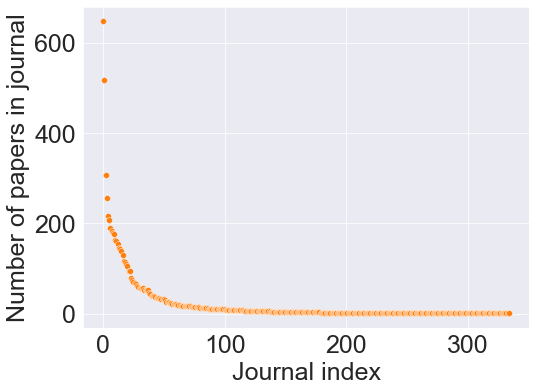

In [355]:
# Distribution of published papers
Published_papers = citation_data["Ref_journal"].value_counts()
Published_papers_list = list(Published_papers)

sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

sns.scatterplot(y=list(citation_data["Ref_journal"].value_counts()), 
                x=list(range(len(citation_data["Ref_journal"].value_counts()))), 
                ax=ax)

sns.scatterplot(y=Published_papers_list, 
                x=list(range(len(Published_papers))), 
                ax=ax)

ax.set_ylabel("Number of papers in journal")
ax.set_xlabel("Journal index")

save_figure(path_figure_folder, fileName="No of papers per journal", fig=fig)

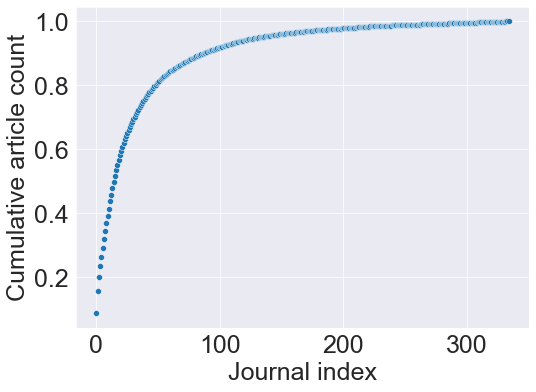

In [357]:
# Cumulative distribution of device papers
"""
44 Journals stands for 80 % of the device papers
80 Journals stands for 90 % of the device papers
120 Journals stands for 95 % of the device papers
"""
Published_papers_list.reverse()
cumulative_article_count = np.cumsum(Published_papers_list)
cumulative_article_count_freq = cumulative_article_count/cumulative_article_count[-1] 

sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

sns.scatterplot(y=cumulative_article_count_freq, 
                x=list(range(len(cumulative_article_count_freq))), 
                ax=ax)

ax.set_ylabel("Cumulative article count")
ax.set_xlabel("Journal index")

save_figure(path_figure_folder, fileName="No of papers per journal cumulative", fig=fig)

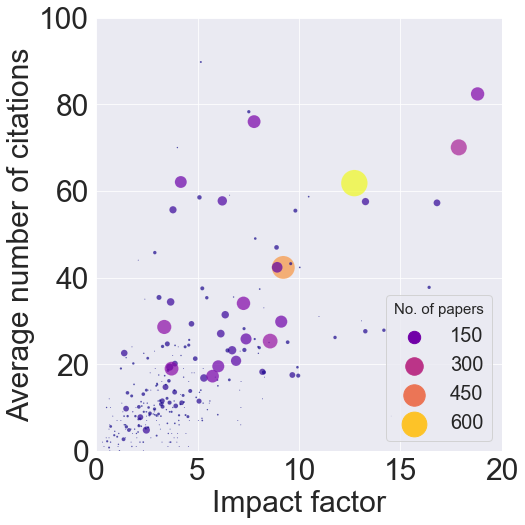

In [373]:
# Citations vs IF for the entire dataset
sns.set_style("darkgrid")
# sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(5, 8), tight_layout=True)

sns.scatterplot(data=data,
                x="IF", 
                y="Citations_mean", 
                hue="count",  
                size="count", 
                sizes=(1, 700),
                alpha=0.7, 
                palette="plasma",
                ax=ax)

ax.set_ylim([0, 100])
ax.set_xlim(xmin=0, xmax=40)

# ax.set_ylim([0, 100])
# ax.set_xlim(xmin=0, xmax=20)

# ax.set_ylim([0, 300])
# ax.set_xlim(xmin=0, xmax=40)

# ax.set_ylim([0, 500])
# ax.set_xlim(xmin=0, xmax=40)

ax.set_ylabel("Average number of citations")
ax.set_xlabel("Impact factor")
ax.legend(title="No. of papers", fontsize=20, title_fontsize=15, loc="lower right")

# save_figure(path_figure_folder, fileName="Citations vs IF zoom 4", fig=fig)

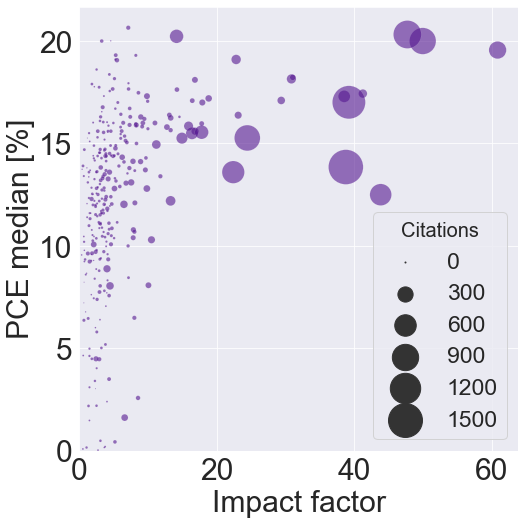

In [387]:
# PCE vs IF for compleat dataset
sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
sns.scatterplot(data=data,
                x="IF", 
                y="PCE_median",   
                size="Citations_median", 
                sizes=(1, 1200),
                alpha=0.6, 
                palette="plasma",
                color="#541690",
                ax=ax)

ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)

ax.set_ylabel("PCE median [%]")
ax.set_xlabel("Impact factor")
ax.legend(title="Citations", fontsize=23, title_fontsize=20)

save_figure(path_figure_folder, fileName="PCE vs IF bubble full dataset", fig=fig)

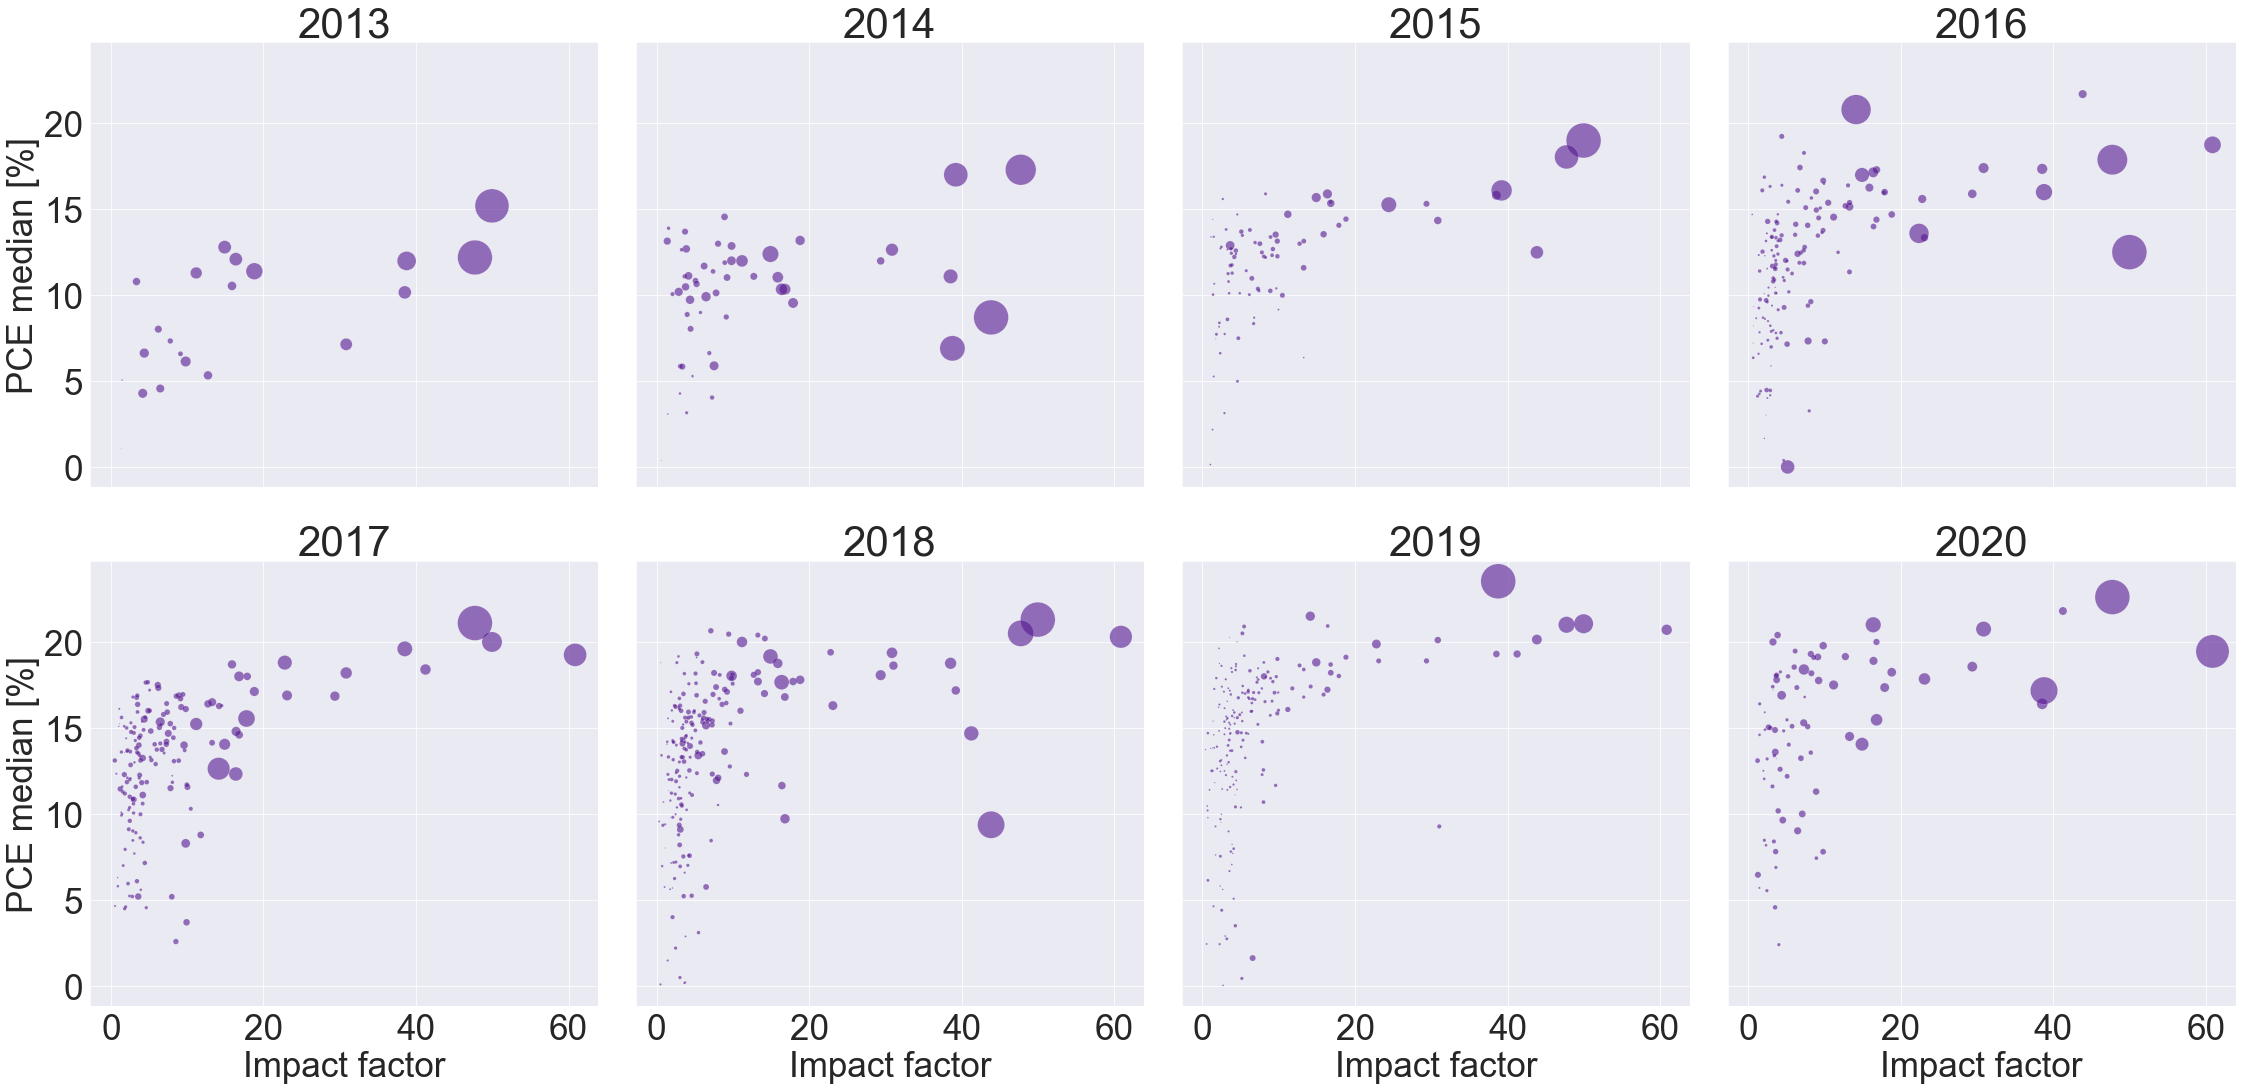

In [388]:
# PCE vs IF with data separated per year
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
col1 = "#541690"

sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(2, 4, figsize=(8*4, 8*2), sharex=True, sharey=True, tight_layout=True)  # Set up a figure
axs_flatten = axs.flat

for i, year in enumerate(years):
    data_year = citation_data[citation_data["date_bins_years"] == year]
    data_temp = data_year[["Ref_journal"]].groupby(by="Ref_journal").size().reset_index(name="count")
    data_temp["IF"] = data_year[["Ref_journal", "Impact_factor"]].groupby(by="Ref_journal").mean().values
    data_temp["PCE_mean"] = data_year[["Ref_journal", "JV_default_PCE"]].groupby(by="Ref_journal").mean().values
    data_temp["PCE_median"] = data_year[["Ref_journal", "JV_default_PCE"]].groupby(by="Ref_journal").median().values
    # data_temp["Citations_mean"] = data_year[["Ref_journal", "Citations"]].groupby(by="Ref_journal").mean().values
    data_temp["Citations_median"] = data_year[["Ref_journal", "Citations"]].groupby(by="Ref_journal").median().values

    line = sns.scatterplot(data=data_temp,
                x="IF", 
                y="PCE_median",  
                size="Citations_median", 
                sizes=(1, 1200),
                alpha=0.6, 
                legend=None,
                color=col1,
                ax=axs_flatten[i])

    axs_flatten[i].set_ylabel("PCE median [%]")
    axs_flatten[i].set_xlabel("Impact factor")
    axs_flatten[i].set_title(f"{year}")
    
save_figure(path_figure_folder, fileName="PCE vs IF bubble separated per year", fig=fig)    

Text(0.5, 1.0, '2019')

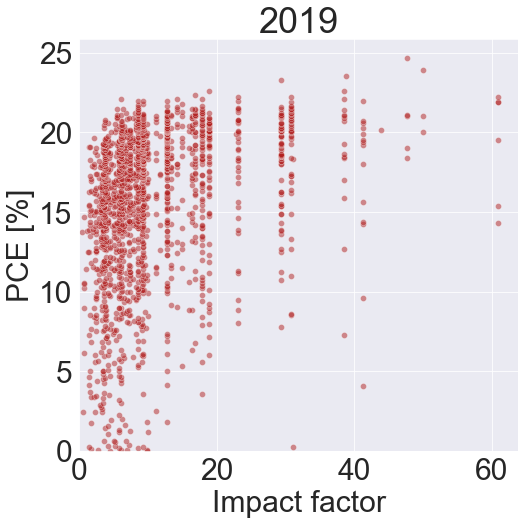

In [389]:
# PCE vs Impact factor scatterplot
year = "2019"
col1 = "firebrick"

data_year = citation_data[citation_data["date_bins_years"] == year]

sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
sns.scatterplot(data=data_year,
                x="Impact_factor", 
                y="JV_default_PCE", 
                alpha=0.5, 
                color=col1,
                ax=ax)

ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)

ax.set_xlabel("Impact factor")
ax.set_ylabel("PCE [%]")
ax.set_title(year)

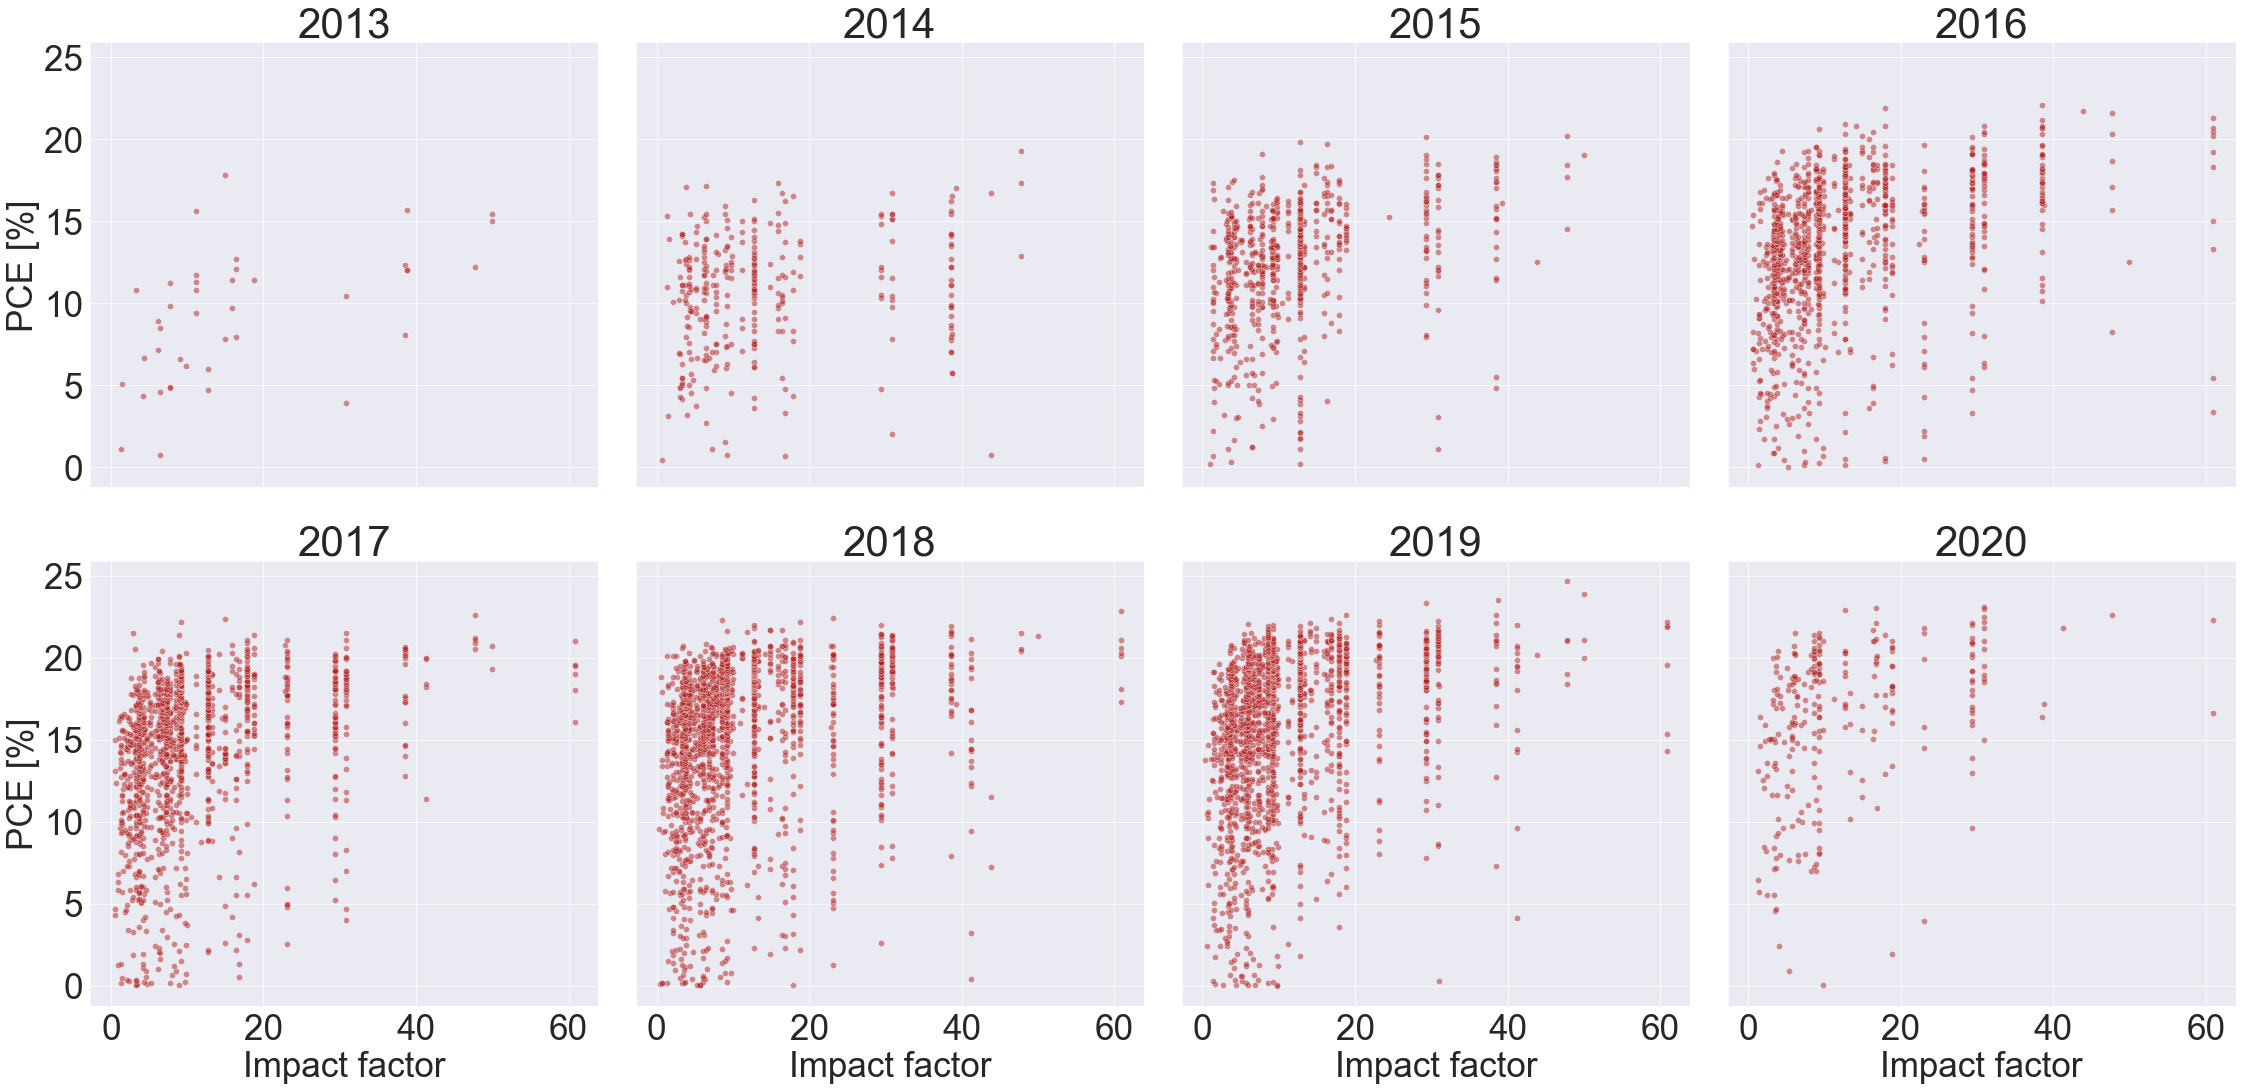

In [390]:
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
col1 = "firebrick"

sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(2, 4, figsize=(8*4, 8*2), sharex=True, sharey=True, tight_layout=True)  # Set up a figure
axs_flatten = axs.flat

for i, year in enumerate(years):
    data_year = citation_data[citation_data["date_bins_years"] == year]

    line = sns.scatterplot(data=data_year,
                x="Impact_factor", 
                y="JV_default_PCE", 
                alpha=0.5, 
                color=col1,
                ax=axs_flatten[i])

    axs_flatten[i].set_ylabel("PCE [%]")
    axs_flatten[i].set_xlabel("Impact factor")
    axs_flatten[i].set_title(f"{year}")

save_figure(path_figure_folder, fileName="PCE vs IF all papers separated per year", fig=fig)      

c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


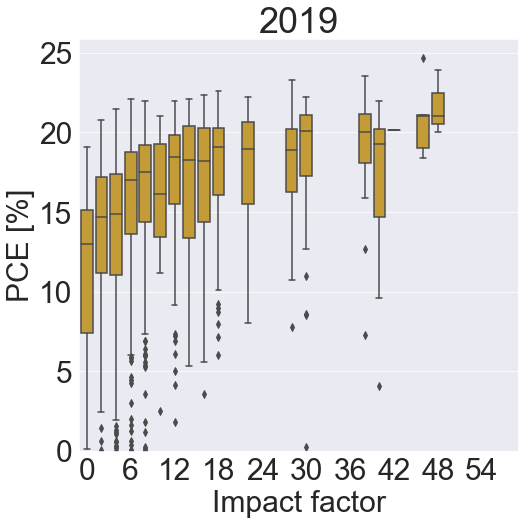

In [393]:
# PCE vs impact factor in the form of a box plot
year = "2019"
data_year = citation_data[citation_data["date_bins_years"] == year]
    
sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)  # Set up a figure

ax = sns.boxplot(data=data_year,
                    x="IF_bins",
                    y="JV_default_PCE",
                    color="goldenrod")

ax_labels = [a.get_text() for a in ax.get_xticklabels()]
ax_labels = [str(int(float(x) - 0.5)) for x in ax_labels]
ax_labels_new = ["" for x in ax_labels]
ax_labels_new[0:-1:3] = ax_labels[0:-1:3]
ax.set(xticklabels=ax_labels_new)

# ax.set_yticks(np.arange(0, 4, step = 0.5))
ax.set_ylim(ymin=0)
ax.set_xlabel("Impact factor")
ax.set_ylabel("PCE [%]")
ax.set_title(f"{year}")

save_figure(path_figure_folder, fileName="PCE vs IF boxplot", fig=fig)   

c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users

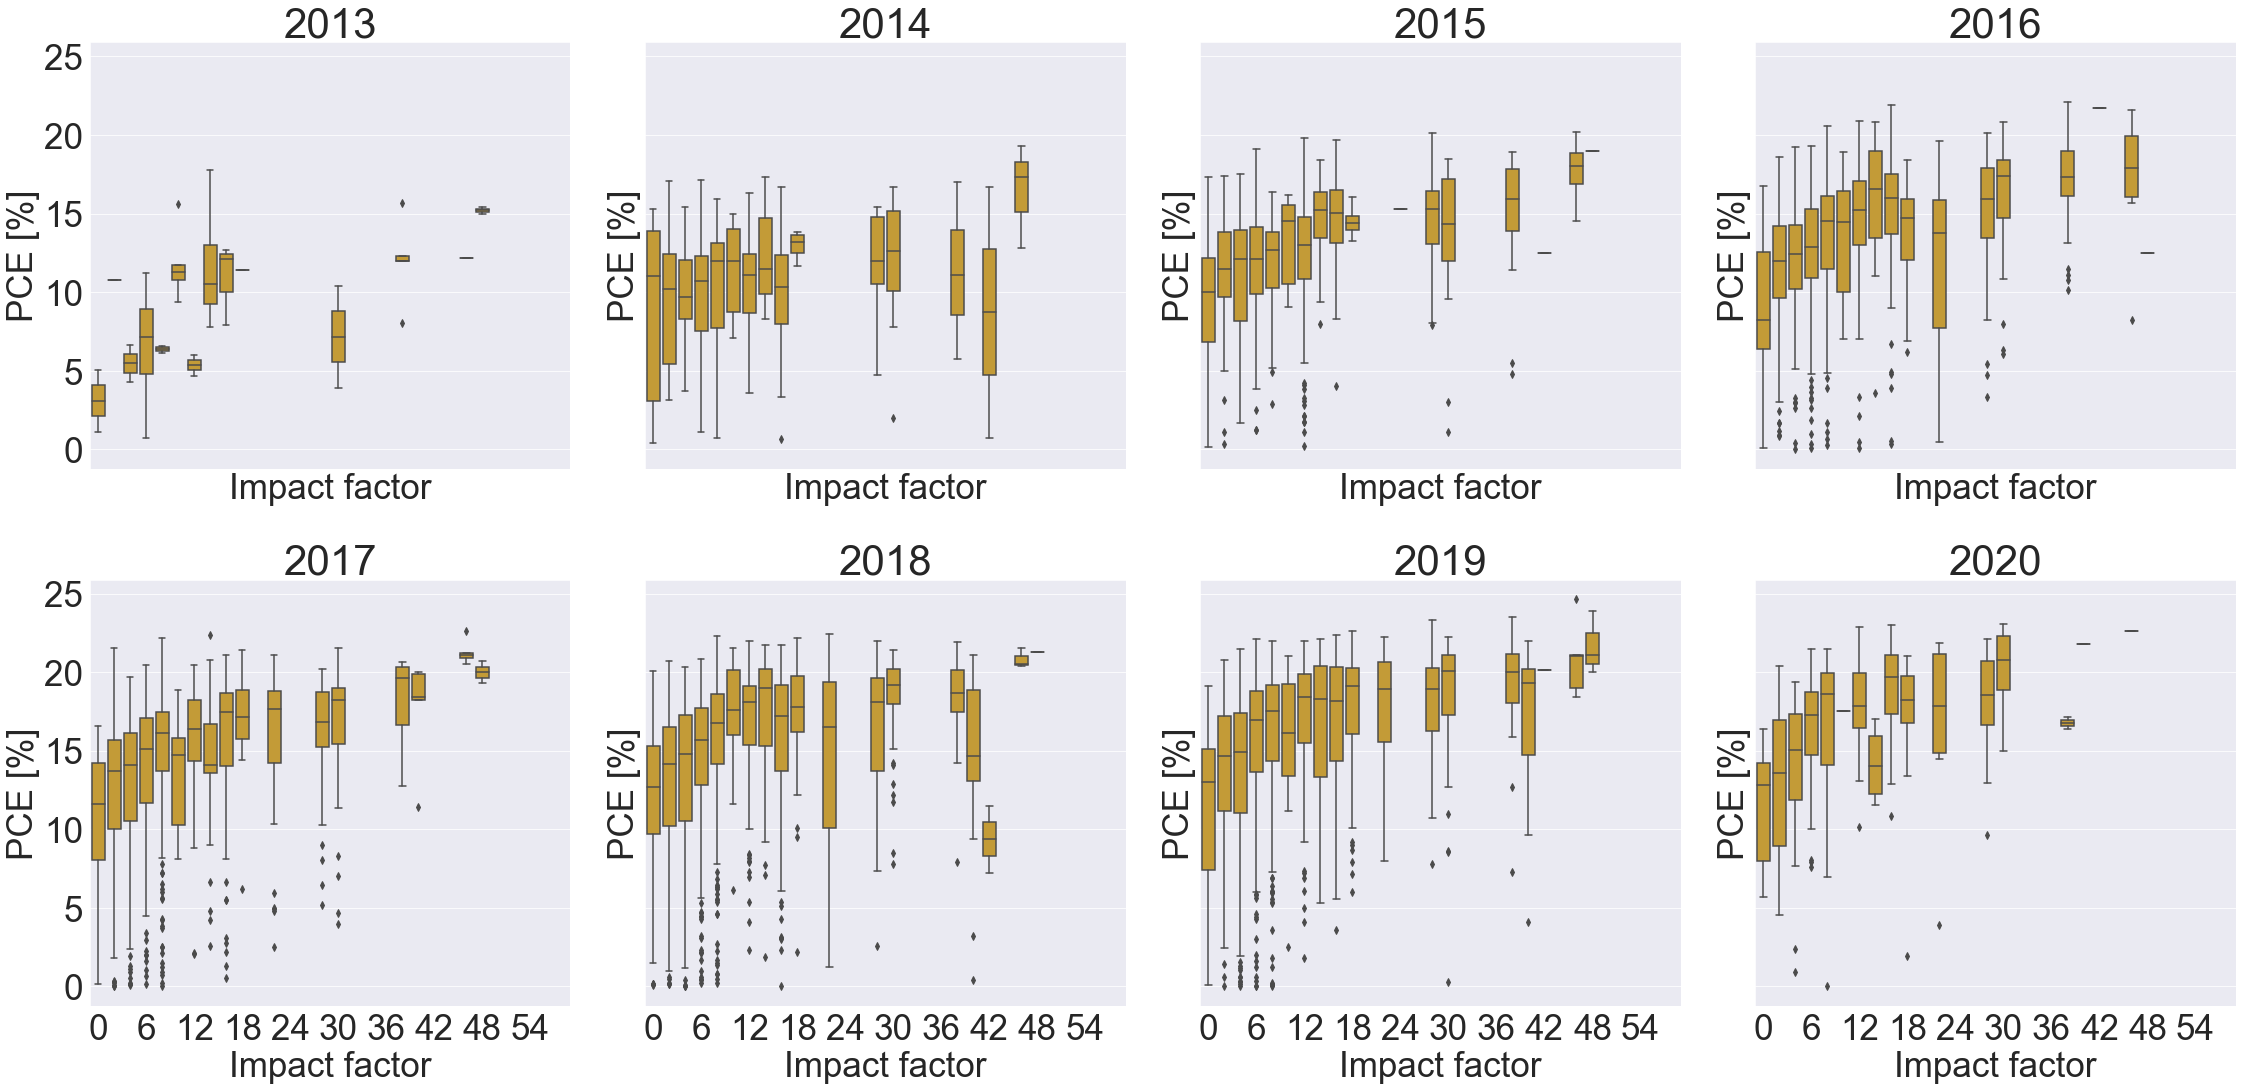

In [394]:
# PCE vs impact factor in the form of a box plot separated by year

years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
col1 = "goldenrod"

sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(2, 4, figsize=(8*4, 8*2), sharex=True, sharey=True, tight_layout=True)  # Set up a figure
axs_flatten = axs.flat

for i, year in enumerate(years):
    data_year = citation_data[citation_data["date_bins_years"] == year]

    line = sns.boxplot(data=data_year,
                x="IF_bins",
                y="JV_default_PCE",
                color=col1,
                ax=axs_flatten[i])

    ax_labels = [a.get_text() for a in axs_flatten[i].get_xticklabels()]
    ax_labels = [str(int(float(x) - 0.5)) for x in ax_labels]
    ax_labels_new = ["" for x in ax_labels]
    ax_labels_new[0:-1:3] = ax_labels[0:-1:3]
    axs_flatten[i].set(xticklabels=ax_labels_new)
    
    axs_flatten[i].set_ylabel("PCE [%]")
    axs_flatten[i].set_xlabel("Impact factor")
    axs_flatten[i].set_title(f"{year}")
    
save_figure(path_figure_folder, fileName="PCE vs IF boxplot separated by year", fig=fig)  

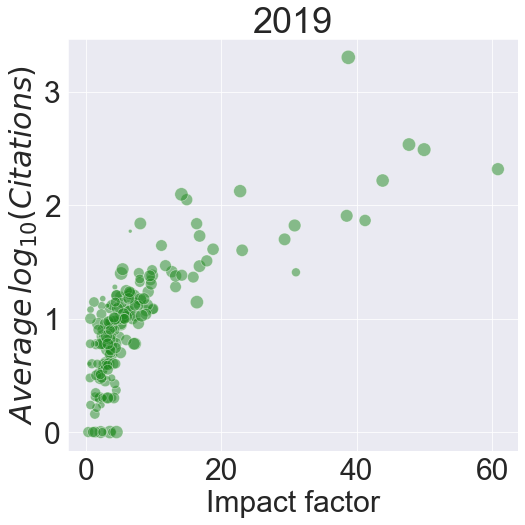

In [397]:
# Citations vs IF
year = "2019"
col1 = "forestgreen"

sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)  # Set up a figure

data_year = citation_data[citation_data["date_bins_years"] == year]
data_temp = data_year[["Ref_journal"]].groupby(by="Ref_journal").size().reset_index(name="count")
data_temp["IF"] = data_year[["Ref_journal", "Impact_factor"]].groupby(by="Ref_journal").mean().values
data_temp["PCE_mean"] = data_year[["Ref_journal", "JV_default_PCE"]].groupby(by="Ref_journal").mean().values
# data_temp["PCE_median"] = data_year[["Ref_journal", "JV_default_PCE"]].groupby(by="Ref_journal").median().values
# data_temp["Citations_mean"] = data_year[["Ref_journal", "Citations"]].groupby(by="Ref_journal").mean().values
# data_temp["Citations_median"] = data_year[["Ref_journal", "Citations"]].groupby(by="Ref_journal").median().values
data_temp["log_Citations_mean"] = data_year[["Ref_journal", "log_citations"]].groupby(by="Ref_journal").mean().values

sns.scatterplot(data=data_temp,
                x="IF", 
                y="log_Citations_mean",  
                size="PCE_mean", 
                sizes=(1, 200),
                alpha=0.5, 
                legend=None,
                color=col1,
                ax=ax)

ax.set_ylabel("$Average\/log_{10}(Citations)$")
ax.set_xlabel("Impact factor")
ax.set_title(f"{year}")

save_figure(path_figure_folder, fileName="Citations vs IF per journal 2019", fig=fig)

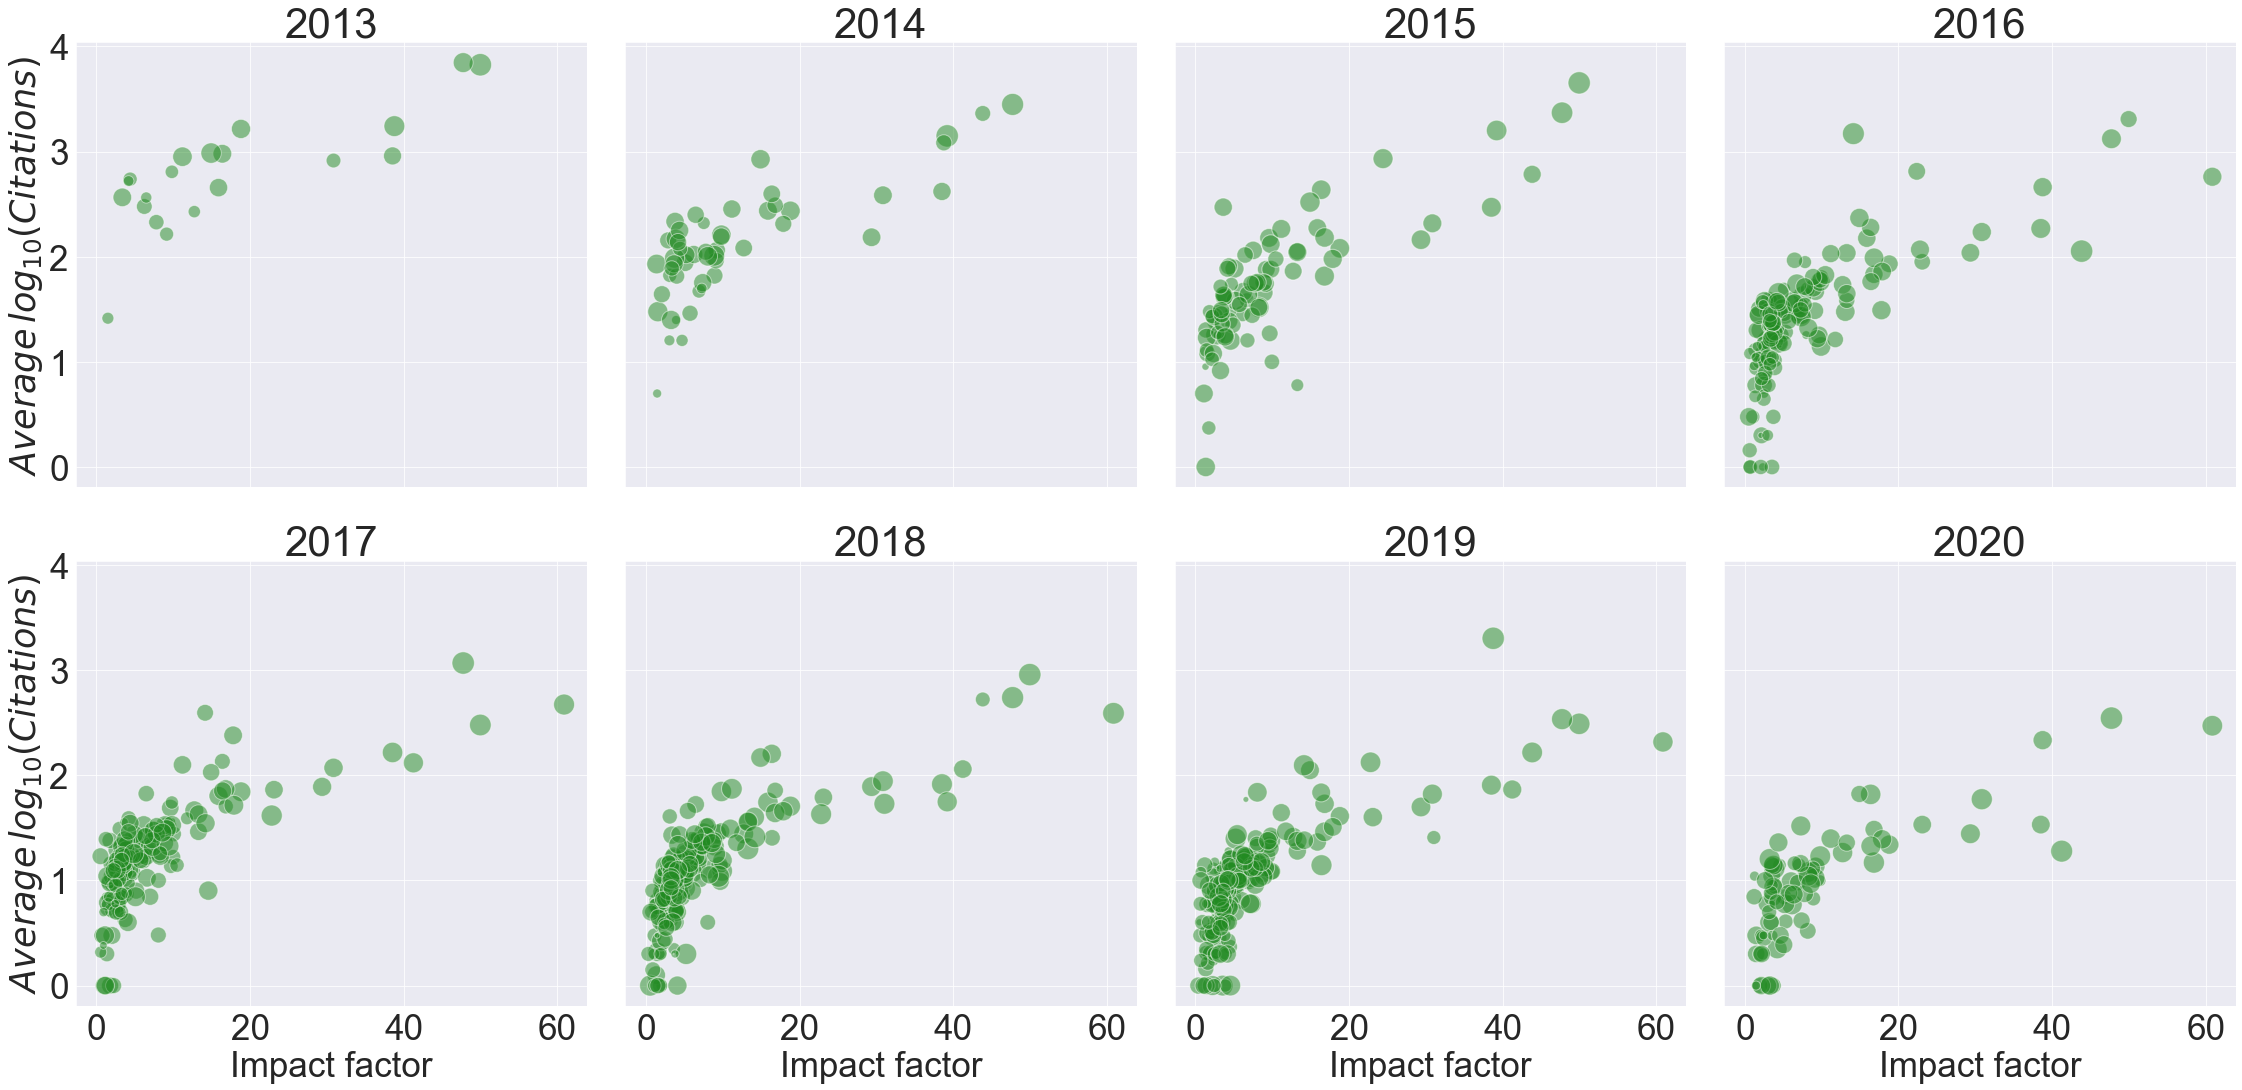

In [398]:
# Citations vs IF for all years
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
col1 = "forestgreen"

sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(2, 4, figsize=(8*4, 8*2), sharex=True, sharey=True, tight_layout=True)  # Set up a figure
axs_flatten = axs.flat

for i, year in enumerate(years):
    data_year = citation_data[citation_data["date_bins_years"] == year]
    data_temp = data_year[["Ref_journal"]].groupby(by="Ref_journal").size().reset_index(name="count")
    data_temp["IF"] = data_year[["Ref_journal", "Impact_factor"]].groupby(by="Ref_journal").mean().values
    data_temp["PCE_mean"] = data_year[["Ref_journal", "JV_default_PCE"]].groupby(by="Ref_journal").mean().values
    # data_temp["PCE_median"] = data_year[["Ref_journal", "JV_default_PCE"]].groupby(by="Ref_journal").median().values
    # data_temp["Citations_mean"] = data_year[["Ref_journal", "Citations"]].groupby(by="Ref_journal").mean().values
    # data_temp["Citations_median"] = data_year[["Ref_journal", "Citations"]].groupby(by="Ref_journal").median().values
    data_temp["log_Citations_mean"] = data_year[["Ref_journal", "log_citations"]].groupby(by="Ref_journal").mean().values

    line = sns.scatterplot(data=data_temp,
                x="IF", 
                y="log_Citations_mean",  
                size="PCE_mean", 
                sizes=(0, 500),
                alpha=0.5, 
                legend=None,
                color=col1,
                ax=axs_flatten[i])

    axs_flatten[i].set_ylabel("$Average\/log_{10}(Citations)$")
    axs_flatten[i].set_xlabel("Impact factor")
    axs_flatten[i].set_title(f"{year}")
    
save_figure(path_figure_folder, fileName="Citations vs IF per journal separated by year", fig=fig)    

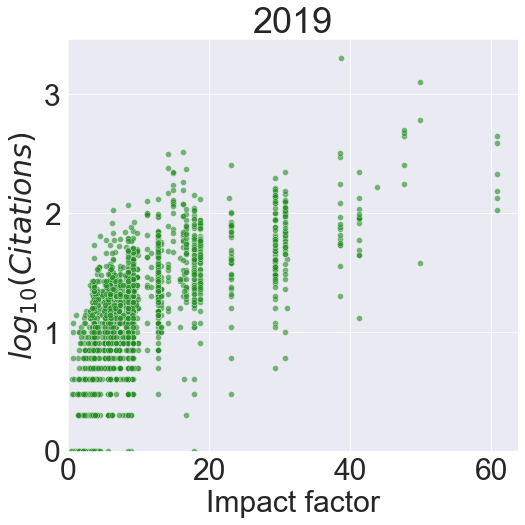

In [399]:
# log citations vs IF for a specific year
year = "2019"
col1 = "forestgreen"
data_year = citation_data[citation_data["date_bins_years"] == year]

sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
sns.scatterplot(data=data_year,
                x="Impact_factor", 
                y="log_citations", 
                # hue="count",  
                # size="count", 
                # sizes=(1, 700),
                alpha=0.6, 
                # palette="plasma",
                color=col1,
                ax=ax)

ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)

ax.set_xlabel("Impact factor")
ax.set_ylabel("$log_{10}(Citations)$")
ax.set_title(year)

save_figure(path_figure_folder, fileName="Citations vs IF all papers 2019", fig=fig)

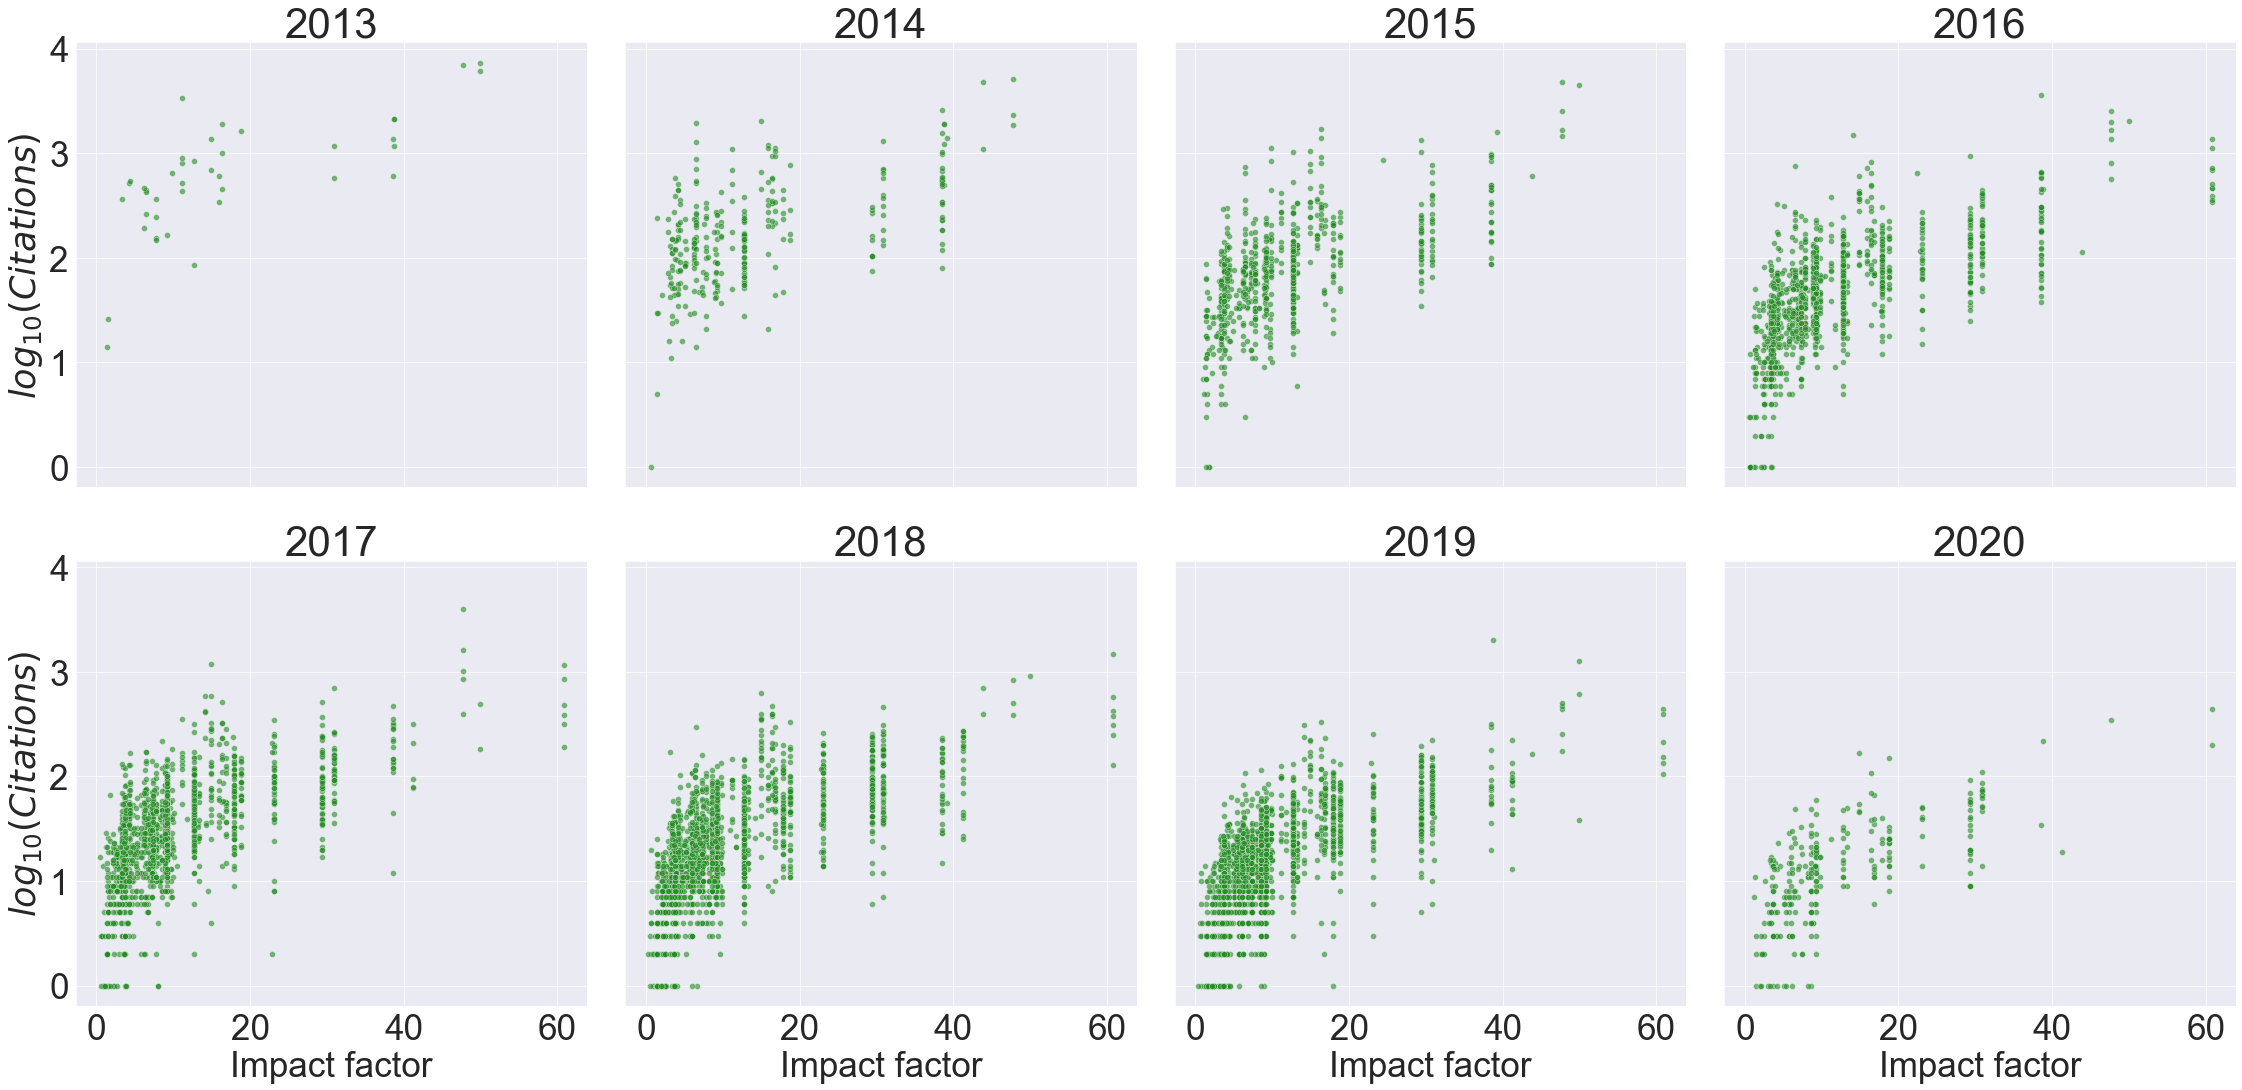

In [400]:
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
col1 = "forestgreen"

sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(2, 4, figsize=(8*4, 8*2), sharex=True, sharey=True, tight_layout=True)  # Set up a figure
axs_flatten = axs.flat

for i, year in enumerate(years):
    data_year = citation_data[citation_data["date_bins_years"] == year]

    line = sns.scatterplot(data=data_year,
                x="Impact_factor", 
                y="log_citations", 
                alpha=0.6,
                color=col1,
                ax=axs_flatten[i])

    axs_flatten[i].set_ylabel("$log_{10}(Citations)$")
    axs_flatten[i].set_xlabel("Impact factor")
    axs_flatten[i].set_title(f"{year}")
    
save_figure(path_figure_folder, fileName="Citations vs IF all papers separated by year", fig=fig)      

c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


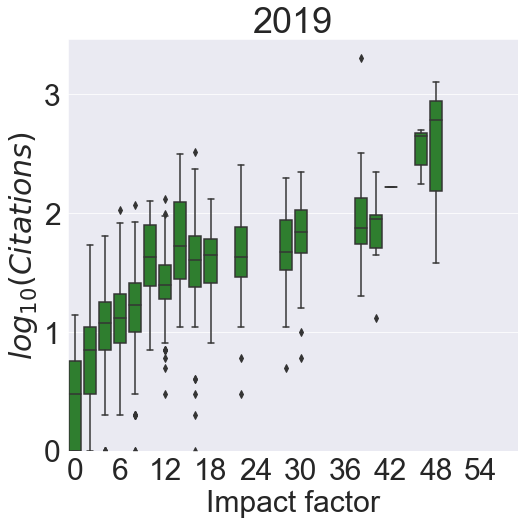

In [401]:
# log citations vs IF for a specific year in the form of a box plot
year = "2019"
col1 = "forestgreen"

data_year = citation_data[citation_data["date_bins_years"] == year]
    
sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)  # Set up a figure

ax = sns.boxplot(data=data_year,
                    x="IF_bins",
                    y="log_citations",
                    color=col1)

ax_labels = [a.get_text() for a in ax.get_xticklabels()]
ax_labels = [str(int(float(x) - 0.5)) for x in ax_labels]
ax_labels_new = ["" for x in ax_labels]
ax_labels_new[0:-1:3] = ax_labels[0:-1:3]
ax.set(xticklabels=ax_labels_new)

# ax.set_yticks(np.arange(0, 4, step = 0.5))
ax.set_ylim(ymin=0)
ax.set_xlabel("Impact factor")
ax.set_ylabel("$log_{10}(Citations)$")
ax.set_title(f"{year}")

save_figure(path_figure_folder, fileName="Citations vs IF boxplot 2019", fig=fig)  

c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users

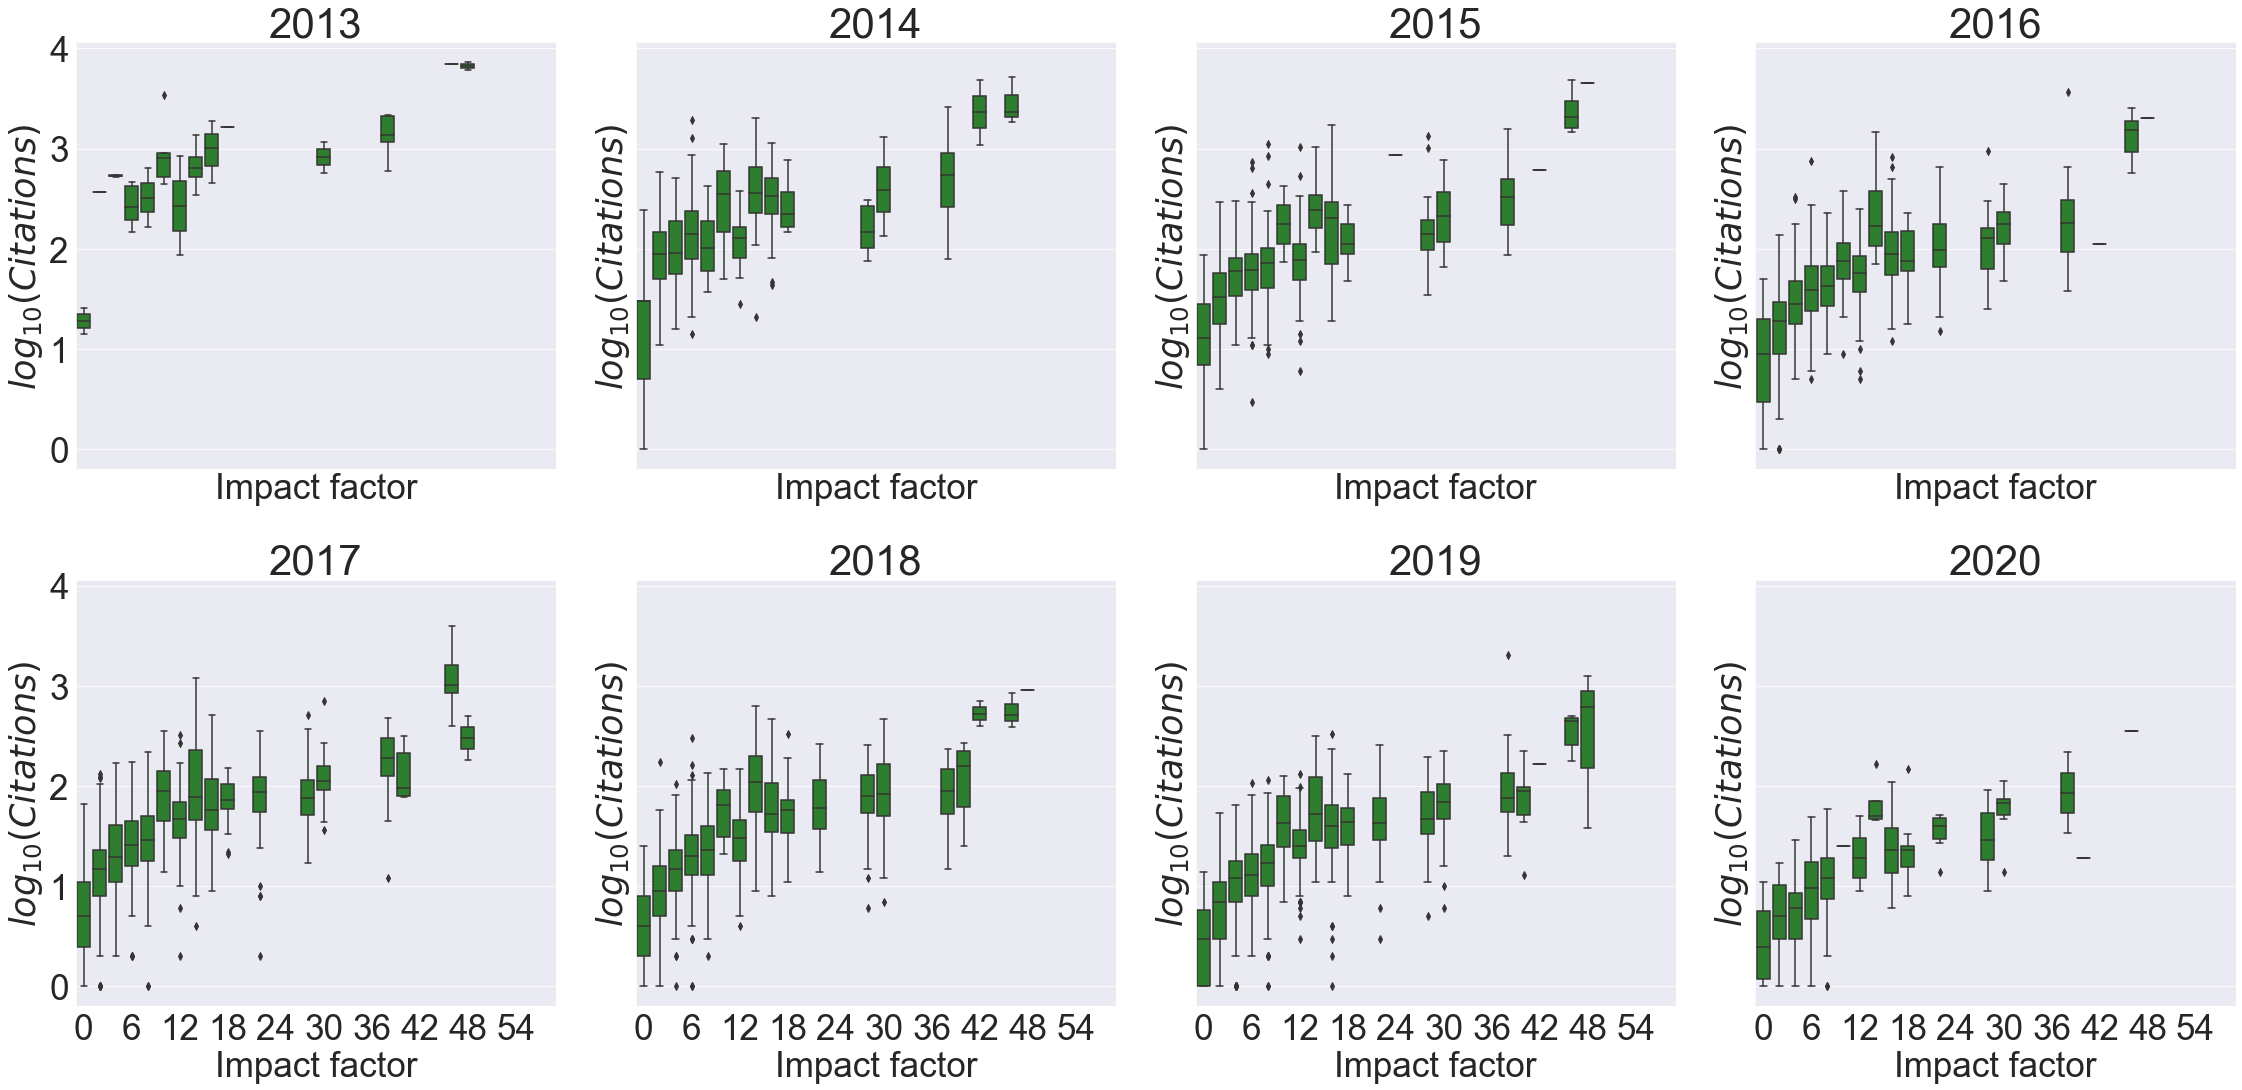

In [402]:
# log citations vs IF for all years in the form of box plots 
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
col1 = "forestgreen"

sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(2, 4, figsize=(8*4, 8*2), sharex=True, sharey=True, tight_layout=True)  # Set up a figure
axs_flatten = axs.flat

for i, year in enumerate(years):
    data_year = citation_data[citation_data["date_bins_years"] == year]

    line = sns.boxplot(data=data_year,
                    x="IF_bins",
                    y="log_citations",
                    color=col1,
                ax=axs_flatten[i])

    ax_labels = [a.get_text() for a in axs_flatten[i].get_xticklabels()]
    ax_labels = [str(int(float(x) - 0.5)) for x in ax_labels]
    ax_labels_new = ["" for x in ax_labels]
    ax_labels_new[0:-1:3] = ax_labels[0:-1:3]
    axs_flatten[i].set(xticklabels=ax_labels_new)

    axs_flatten[i].set_ylabel("$log_{10}(Citations)$")
    axs_flatten[i].set_xlabel("Impact factor")
    axs_flatten[i].set_title(f"{year}")  
    
save_figure(path_figure_folder, fileName="Citations vs IF boxplot separated by year", fig=fig)       

c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


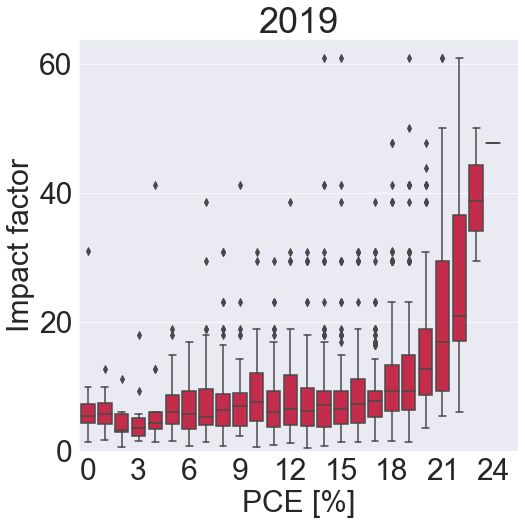

In [403]:
# Impact factor vs PCS
year = "2019"
col1 = "crimson"
data_year = citation_data[citation_data["date_bins_years"] == year]
    
sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)  # Set up a figure

ax = sns.boxplot(data=data_year,
                    x="PCE_bins",
                    y="Impact_factor",
                    color=col1)

ax_labels = [a.get_text() for a in ax.get_xticklabels()]
ax_labels = [str(int(float(x) - 0.5)) for x in ax_labels]
ax_labels_new = ["" for x in ax_labels]
ax_labels_new[0:-1:3] = ax_labels[0:-1:3]
ax.set(xticklabels=ax_labels_new)

# ax.set_yticks(np.arange(0, 4, step = 0.5))
ax.set_ylim(ymin=0)
ax.set_ylabel("Impact factor")
ax.set_xlabel("PCE [%]")
ax.set_title(f"{year}")

save_figure(path_figure_folder, fileName="IF vs PCE boxplot 2019", fig=fig) 

c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users

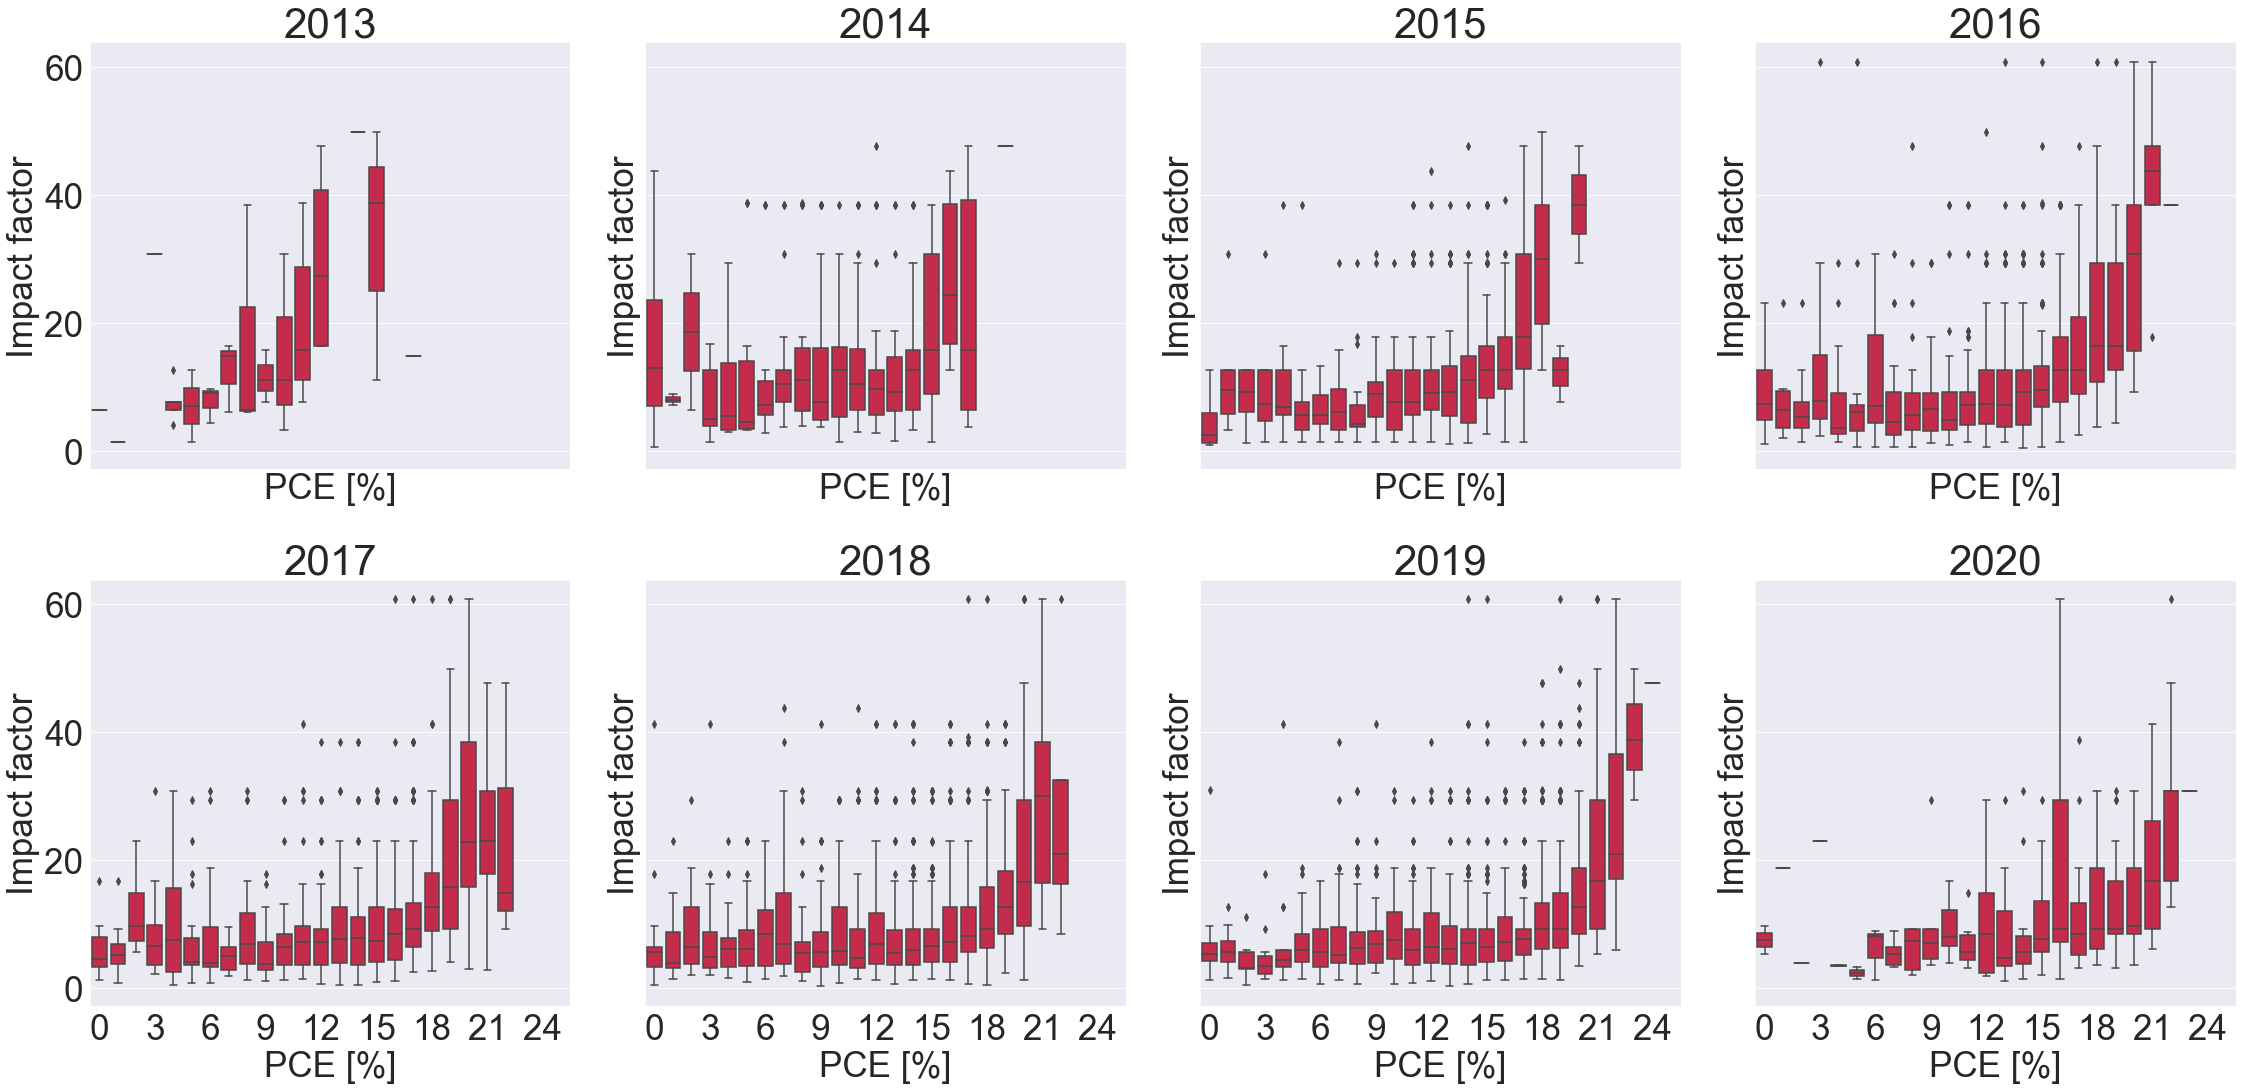

In [404]:
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
col1 = "crimson"

sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(2, 4, figsize=(8*4, 8*2), sharex=True, sharey=True, tight_layout=True)  # Set up a figure
axs_flatten = axs.flat

for i, year in enumerate(years):
    data_year = citation_data[citation_data["date_bins_years"] == year]

    line = sns.boxplot(data=data_year,
                    x="PCE_bins",
                    y="Impact_factor",
                    color=col1,
                ax=axs_flatten[i])

    ax_labels = [a.get_text() for a in axs_flatten[i].get_xticklabels()]
    ax_labels = [str(int(float(x) - 0.5)) for x in ax_labels]
    ax_labels_new = ["" for x in ax_labels]
    ax_labels_new[0:-1:3] = ax_labels[0:-1:3]
    axs_flatten[i].set(xticklabels=ax_labels_new)

    axs_flatten[i].set_ylabel("Impact factor")
    axs_flatten[i].set_xlabel("PCE [%]")
    axs_flatten[i].set_title(f"{year}") 
    
save_figure(path_figure_folder, fileName="IF vs PCE boxplot all years", fig=fig) 

In [345]:
# Generate linear fit metrics
# log citations vs IF
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]

intercepts_1 = []
sloop_1 = []
sloop_1_non_log = []
MSE_1 = []
RMSE_1 = []
MAE_1 = []
r2_1 = []

for year in years:
    data_year = citation_data[citation_data["date_bins_years"] == year]
    
    x1 = data_year["Impact_factor"].values.reshape((-1, 1))
    y1 = data_year["log_citations"].values
    
    model1 = LinearRegression(fit_intercept=True).fit(x1, y1)
    y_pred1 = model1.predict(x1)
    
    intercepts_1.append(model1.intercept_)
    sloop_1.append(model1.coef_[0])
    sloop_1_non_log.append(10**(model1.coef_[0]))
    MSE_1.append(metrics.mean_squared_error(y1, y_pred1))
    RMSE_1.append(metrics.mean_squared_error(y1, y_pred1, squared=False))
    MAE_1.append(metrics.mean_absolute_error(y1, y_pred1))
    r2_1.append(metrics.r2_score(y1, y_pred1))
    
# Combine metrics to a pandas datafram
metrics_data = pd.DataFrame(list(zip(intercepts_1, sloop_1, sloop_1_non_log, MSE_1, RMSE_1, MAE_1, r2_1,)),
                            columns=["Intercept_1", "Sloop_1", "Sloop_1_2", "MSE_1", "RMSE_1", "MEA_1", "r2_1"],
                            index=years)

metrics_data.round(3).to_csv("Linear fit citations vs IF summary.csv")

metrics_data.round(3)

,Intercept_1,Sloop_1,Sloop_1_2,MSE_1,RMSE_1,MEA_1,r2_1
2013,2.285,0.028,1.067,0.151,0.389,0.296,0.506
2014,1.896,0.023,1.055,0.164,0.405,0.311,0.302
2015,1.502,0.031,1.073,0.155,0.394,0.301,0.346
2016,1.280,0.031,1.074,0.151,0.389,0.292,0.420
2017,1.122,0.033,1.079,0.153,0.392,0.299,0.378
2018,0.980,0.034,1.080,0.151,0.389,0.299,0.416
2019,0.835,0.035,1.083,0.136,0.369,0.286,0.413
2020,0.694,0.033,1.078,0.132,0.364,0.287,0.451


In [348]:
# Generate linear fit metrics
# log citations vs PCE
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]

intercepts_1 = []
sloop_1 = []
sloop_1_non_log = []
MSE_1 = []
RMSE_1 = []
MAE_1 = []
r2_1 = []

for year in years:
    data_year = citation_data[citation_data["date_bins_years"] == year]
    
    x1 = data_year["Impact_factor"].values.reshape((-1, 1))
    y1 = data_year["JV_default_PCE"].values
    
    model1 = LinearRegression(fit_intercept=True).fit(x1, y1)
    y_pred1 = model1.predict(x1)
    
    intercepts_1.append(model1.intercept_)
    sloop_1.append(model1.coef_[0])
    sloop_1_non_log.append(10**(model1.coef_[0]))
    MSE_1.append(metrics.mean_squared_error(y1, y_pred1))
    RMSE_1.append(metrics.mean_squared_error(y1, y_pred1, squared=False))
    MAE_1.append(metrics.mean_absolute_error(y1, y_pred1))
    r2_1.append(metrics.r2_score(y1, y_pred1))
    
# Combine metrics to a pandas datafram
metrics_data = pd.DataFrame(list(zip(intercepts_1, sloop_1, sloop_1_non_log, MSE_1, RMSE_1, MAE_1, r2_1,)),
                            columns=["Intercept_1", "Sloop_1", "Sloop_1_2", "MSE_1", "RMSE_1", "MEA_1", "r2_1"],
                            index=years)

metrics_data.round(3).to_csv("Linear fit PCE vs IF summary.csv")

metrics_data.round(3)

,Intercept_1,Sloop_1,Sloop_1_2,MSE_1,RMSE_1,MEA_1,r2_1
2013,6.634,0.150,1.412,11.303,3.362,2.660,0.281
2014,9.735,0.058,1.143,12.409,3.523,2.838,0.035
2015,10.729,0.133,1.358,12.607,3.551,2.712,0.110
2016,11.675,0.132,1.355,16.159,4.020,3.091,0.109
2017,12.610,0.153,1.422,18.189,4.265,3.276,0.099
2018,13.443,0.129,1.345,21.320,4.617,3.599,0.069
2019,13.957,0.155,1.429,20.260,4.501,3.526,0.086
2020,14.037,0.166,1.466,19.311,4.394,3.484,0.128
